In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfilt

In [69]:
log_filename = "log023.csv"
df = pd.read_csv("logs/" + log_filename)

In [70]:
def get_spherical(x, y, z):
    r = (x**2 + y**2 + z**2)**0.5
    theta = np.arccos(z / r)  # polar angle
    phi = np.arctan2(y, x)  # azimuthal angle
    return r, theta, phi

accel_spherical = []
accel_cartesian = []
for lis_index in range(2):
    accel_spherical_i = []
    for row in range(len(df)):
        x = df[f"lis{lis_index + 1}_x"][row]
        y = df[f"lis{lis_index + 1}_y"][row]
        z = df[f"lis{lis_index + 1}_z"][row]
        accel_spherical_i.append(get_spherical(x, y, z))
    accel_spherical.append(accel_spherical_i)
    accel_cartesian.append(df[[f"lis{lis_index + 1}_x", f"lis{lis_index + 1}_y", f"lis{lis_index + 1}_z"]].values)

accel_spherical = np.array(accel_spherical, dtype=np.float32)
accel_cartesian = np.array(accel_cartesian, dtype=np.float32)

accel_spherical *= 9.81 / 1000 # Convert from milli-g to m/s^2
accel_cartesian *= 9.81 / 1000 # Convert from milli-g to m/s^2

time_ms = df["t_ms"].values

print(accel_spherical.shape)  # Should be (2, num_rows, 3)
print(accel_cartesian.shape)  # Should be (2, num_rows, 3)



(2, 86612, 3)
(2, 86612, 3)


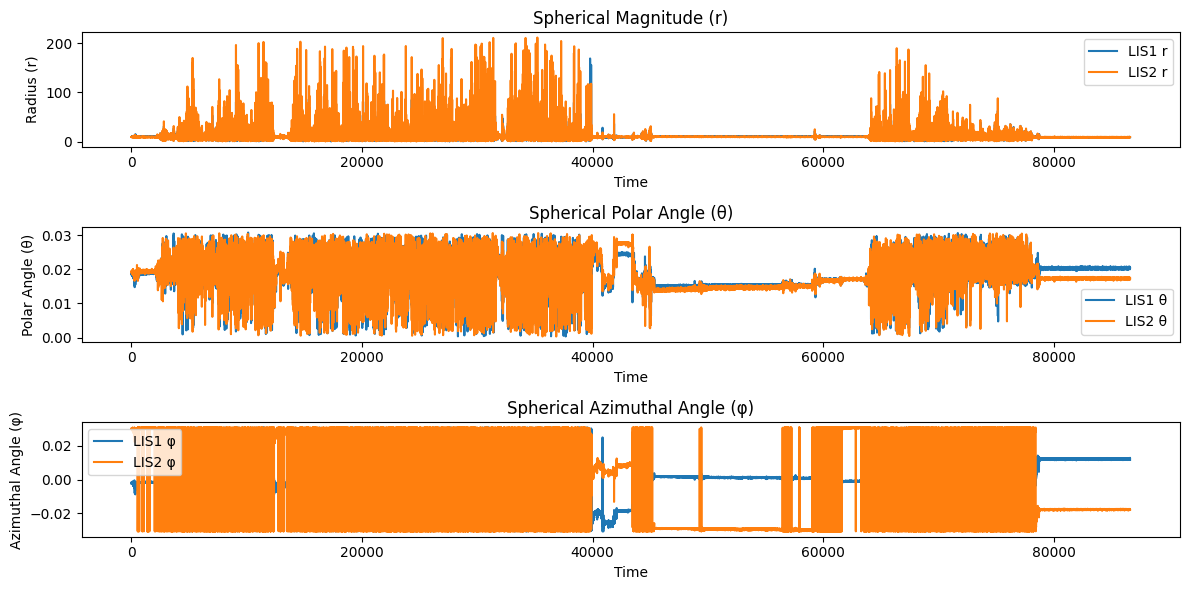

In [71]:
# Plotting the spherical components for both sensors
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(accel_spherical[0][:, 0], label="LIS1 r")
plt.plot(accel_spherical[1][:, 0], label="LIS2 r")
plt.title("Spherical Magnitude (r)")
plt.xlabel("Time")
plt.ylabel("Radius (r)")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(accel_spherical[0][:, 1], label="LIS1 θ")
plt.plot(accel_spherical[1][:, 1], label="LIS2 θ")
plt.title("Spherical Polar Angle (θ)")
plt.xlabel("Time")
plt.ylabel("Polar Angle (θ)")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(accel_spherical[0][:, 2], label="LIS1 φ")
plt.plot(accel_spherical[1][:, 2], label="LIS2 φ")
plt.title("Spherical Azimuthal Angle (φ)")
plt.xlabel("Time")
plt.ylabel("Azimuthal Angle (φ)")
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
# Filter the acceleration data for motion

fc_hz = 20
fs = 100

sos = butter(N=4, Wn=fc_hz, btype="low", fs=fs, output="sos")

accel_filtered = sosfiltfilt(sos, accel_cartesian, axis=1)

[[-0.99930845 -0.02964975  0.02243911]
 [ 0.03530206 -0.94604874  0.32209556]
 [ 0.01167844  0.32266496  0.9464412 ]]
(86612, 3)
[-0.35404297 -0.14541887  0.05015141]


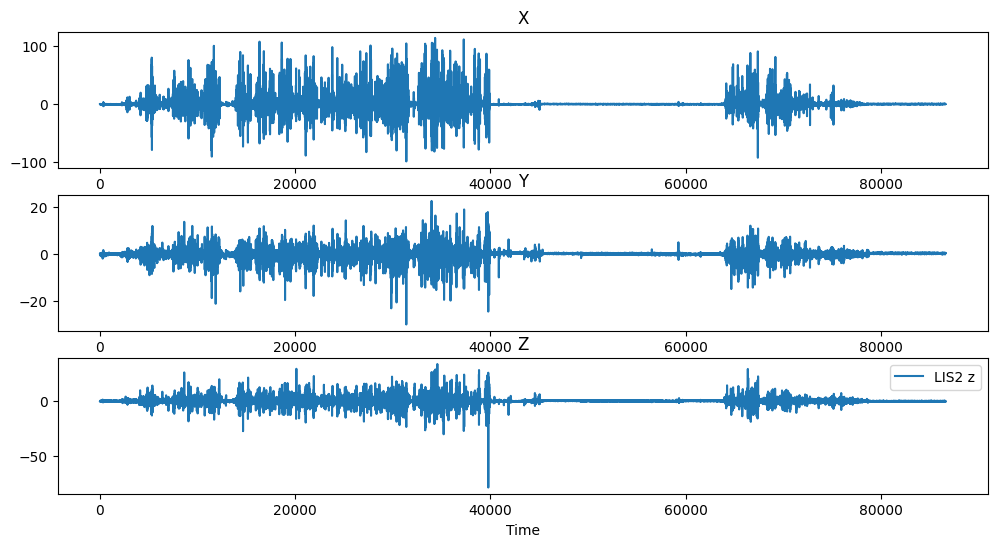

In [73]:
# Load rotation matrix, apply it to sensor 2, and get the net acceleration
R_2_to_1 = np.load(f"accel_rotation_2_to_1_{log_filename}.npy")
print(R_2_to_1)
s2_in_s1 = (R_2_to_1 @ accel_filtered[1].T).T

net_accel = s2_in_s1 - accel_filtered[0]
print(net_accel.shape)
print(np.mean(net_accel, axis=0))

def plot_xyz(data):
    # Plot velocities
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(data[:, 0], label="LIS2 x")
    plt.title("X")
    plt.subplot(3, 1, 2)
    plt.plot(data[:, 1], label="LIS2 y")
    plt.title("Y")
    plt.subplot(3, 1, 3)
    plt.plot(data[:, 2], label="LIS2 z")
    plt.title("Z")
    plt.xlabel("Time")
    plt.legend()

plot_xyz(net_accel)

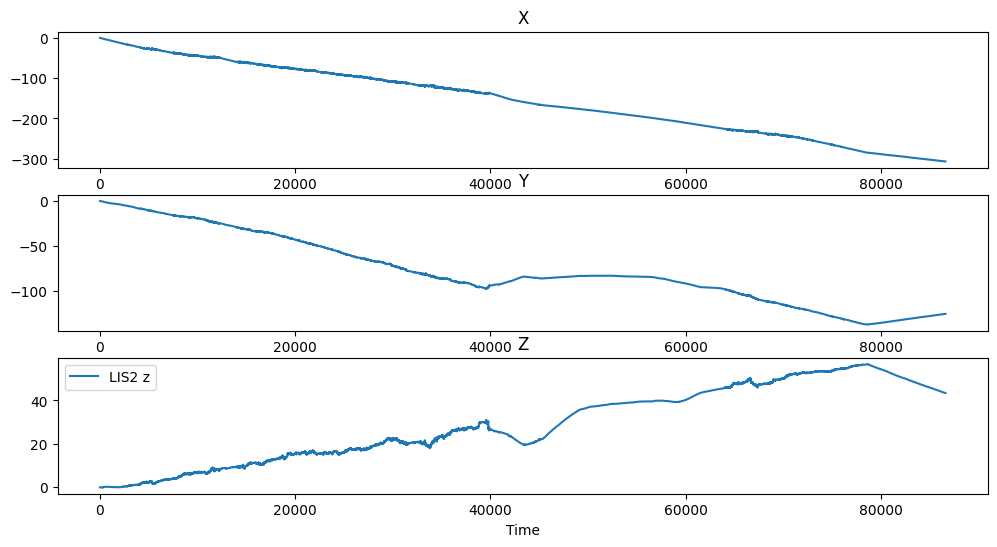

In [74]:
# Plot velocities by integrating acceleration
# Position of both sensors should be approximately the same

# time step per sample in seconds (shape: (T,))
dt_s = np.diff(time_ms, prepend=time_ms[0]) / 1000.0

# broadcast to (S, T, A) and compute dv
dv = net_accel * dt_s[:, None]
velocities = np.cumsum(dv, axis=0)

plot_xyz(velocities)

[-306.61060839 -125.9604866    43.42983031]
[-0.35400885 -0.14543244  0.05014355]


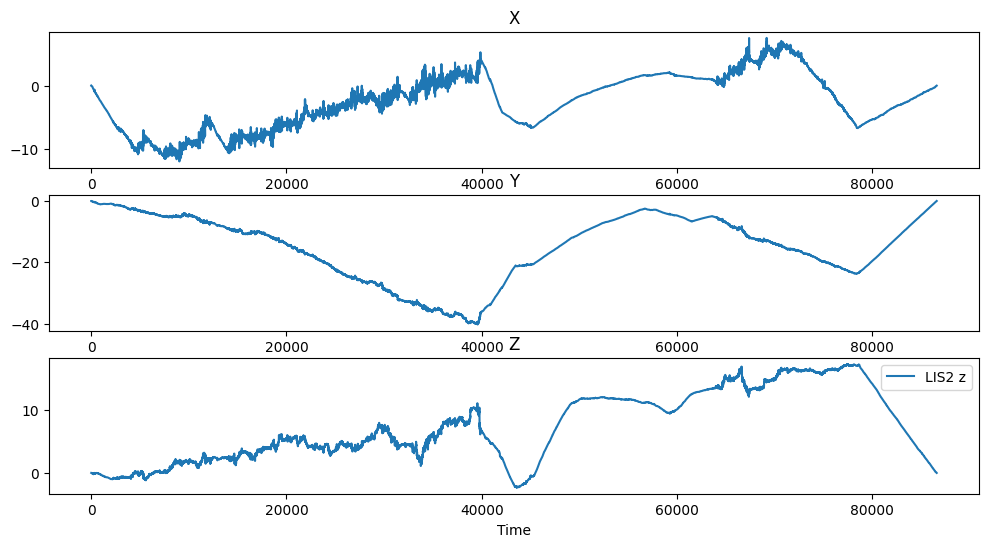

In [75]:
# Correct for velocities and save the new net acceleration
end_v = velocities[-1]
print(end_v)
# assume it should be basically zero
error_v = end_v
error_a = error_v / ((time_ms[-1] - time_ms[0]) / 1000)
print(error_a)

new_s2_in_s1 = s2_in_s1 - error_a
new_net_accel = new_s2_in_s1 - accel_filtered[0]

# broadcast to (S, T, A) and compute dv
dv = new_net_accel * dt_s[:, None]
velocities_new = np.cumsum(dv, axis=0)

plot_xyz(velocities_new)


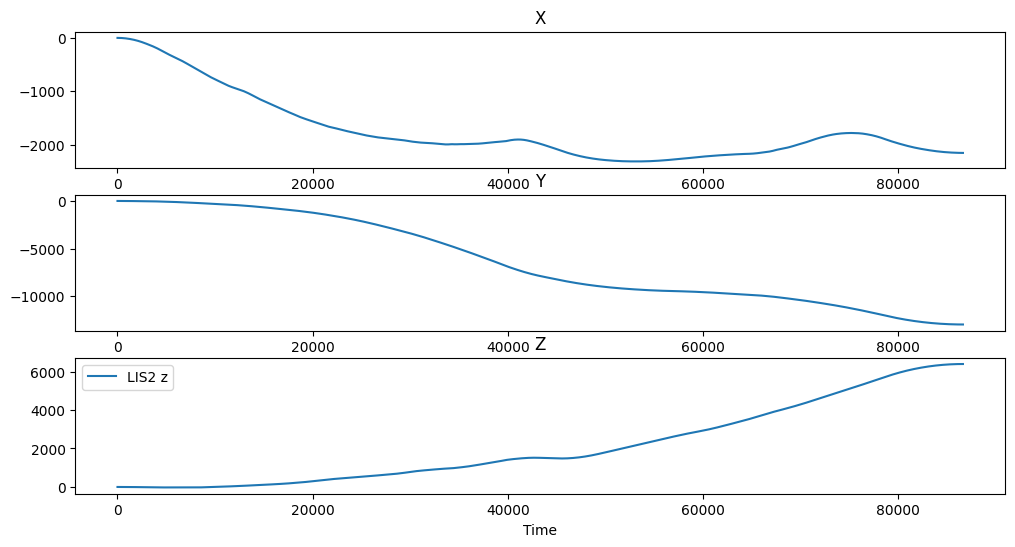

In [76]:
positions = np.cumsum(velocities_new * dt_s[:, None], axis=0)
plot_xyz(positions)

In [77]:
# Break net accel into chunks
chunk_size = 10

accel_chunks = []
for i in range(0, new_net_accel.shape[0], chunk_size):
    chunk = new_net_accel[i : i + chunk_size, :]
    if chunk.shape[0] == chunk_size:  # Only keep full chunks
        accel_chunks.append(chunk)

print(len(accel_chunks), "chunks found")


8661 chunks found


320 interesting chunks found
(320, 10, 3)
(320, 3)
[-0.99954224 -0.00697825 -0.02943845]


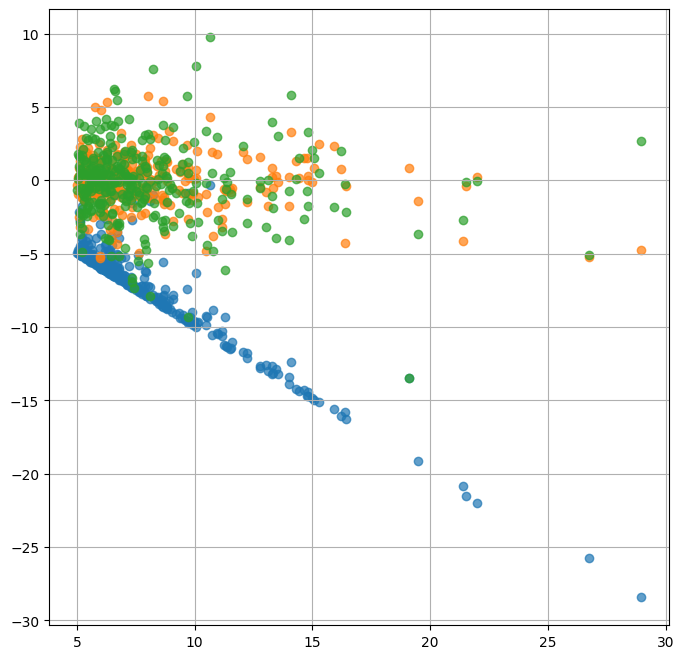

In [78]:
# Threshold chunk acceleration and only get ones with positive X accel

good_chunks = []
accel_threshold = 5 # m/s^2

for chunk in accel_chunks:
    chunk_net_magnitude = np.linalg.norm(np.mean(chunk, axis=0))
    if chunk_net_magnitude > accel_threshold:
        if np.mean(chunk, axis=0)[0] < 0: # Only keep chunks with net negative X acceleration
            good_chunks.append(chunk)

print(len(good_chunks), "interesting chunks found")

good_chunks = np.array(good_chunks)
print(good_chunks.shape)
chunk_means = np.mean(good_chunks, axis=1)
chunk_mags = np.linalg.norm(chunk_means, axis=1)
print(chunk_means.shape)

# Plot scatter of angle vs travel
# Scatter plot of vectors
plt.figure(figsize=(8, 8))
plt.scatter(chunk_mags, chunk_means[:, 0], alpha=0.7)
plt.scatter(chunk_mags, chunk_means[:, 1], alpha=0.7)
plt.scatter(chunk_mags, chunk_means[:, 2], alpha=0.7)
plt.grid()

travel_vector = np.mean(chunk_means, axis=0) / np.linalg.norm(np.mean(chunk_means, axis=0))
print(travel_vector)

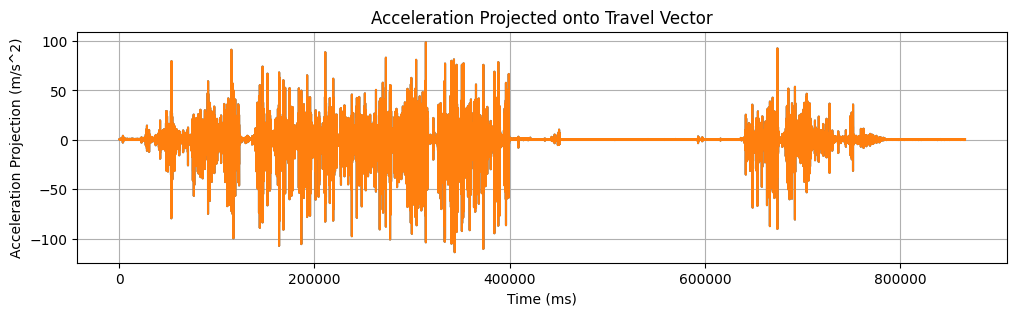

In [79]:
net_accel_i = net_accel
#net_accel_i = new_net_accel

# Project accel onto travel vector and save it
travel_unit_vector = travel_vector / np.linalg.norm(travel_vector)
accel_projection = net_accel_i @ travel_unit_vector

# Rotate net accel to be aligned with travel vector
# Get rotation matrix that rotates travel vector to x-axis
def rotation_matrix_from_vectors(vec1, vec2):
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    if s == 0:
        return np.eye(3)  # No rotation needed
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s**2))
    return rotation_matrix
R_travel_to_x = rotation_matrix_from_vectors(travel_vector, np.array([1, 0, 0]))
accel_aligned = (R_travel_to_x @ net_accel_i.T).T

np.save(f"net_accel_projected_{log_filename}.npy", accel_aligned)

plt.figure(figsize=(12, 3))
plt.plot(time_ms, accel_projection)
plt.plot(time_ms, accel_aligned[:, 0], label="Aligned with Travel Vector")
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration Projection (m/s^2)")
plt.title("Acceleration Projected onto Travel Vector")
plt.grid()
plt.show()